In [1]:
import sys
print(sys.version)


3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import joblib

print("All libraries imported successfully")



All libraries imported successfully


In [3]:
import pandas as pd

df = pd.read_csv("click_fraud_dataset.csv")
print(df.shape)
df.head()

(5000, 21)


,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0
3,01fc0078-096b-4f90-82ae-aa8085b719ac,2024-10-12 08:18:14,d30788b2-4048-4770-a4b1-a9358788818f,216.146.33.78,Tablet,Edge,macOS,https://jones-mendoza.com/,https://www.alvarado.com/,4.29,...,472,37,Side,4,33,Suspicious,0,0,0.65,0
4,0afdf2af-0b48-47d5-bfb6-e087053e1eb9,2024-04-19 14:44:35,dfc42287-6325-4344-b373-b8e61ea6e5c1,146.37.54.245,Desktop,Opera,Windows,https://www.griffith-holloway.com/,http://gonzalez.com/,2.46,...,50,2,Side,7,97,Good,0,0,0.06,0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   click_id               5000 non-null   object 
 1   timestamp              5000 non-null   object 
 2   user_id                5000 non-null   object 
 3   ip_address             5000 non-null   object 
 4   device_type            5000 non-null   object 
 5   browser                5000 non-null   object 
 6   operating_system       5000 non-null   object 
 7   referrer_url           5000 non-null   object 
 8   page_url               5000 non-null   object 
 9   click_duration         5000 non-null   float64
 10  scroll_depth           5000 non-null   int64  
 11  mouse_movement         5000 non-null   int64  
 12  keystrokes_detected    5000 non-null   int64  
 13  ad_position            5000 non-null   object 
 14  click_frequency        5000 non-null   int64  
 15  time

In [5]:
list(df.columns)


['click_id',
 'timestamp',
 'user_id',
 'ip_address',
 'device_type',
 'browser',
 'operating_system',
 'referrer_url',
 'page_url',
 'click_duration',
 'scroll_depth',
 'mouse_movement',
 'keystrokes_detected',
 'ad_position',
 'click_frequency',
 'time_since_last_click',
 'device_ip_reputation',
 'VPN_usage',
 'proxy_usage',
 'bot_likelihood_score',
 'is_fraudulent']

In [6]:
df['is_fraudulent'].value_counts()

is_fraudulent
0    3759
1    1241
Name: count, dtype: int64

In [7]:
df['is_fraudulent'].value_counts(normalize=True)


is_fraudulent
0    0.7518
1    0.2482
Name: proportion, dtype: float64

In [8]:
df.isnull().sum().sort_values(ascending=False)


click_id                 0
mouse_movement           0
bot_likelihood_score     0
proxy_usage              0
VPN_usage                0
device_ip_reputation     0
time_since_last_click    0
click_frequency          0
ad_position              0
keystrokes_detected      0
scroll_depth             0
timestamp                0
click_duration           0
page_url                 0
referrer_url             0
operating_system         0
browser                  0
device_type              0
ip_address               0
user_id                  0
is_fraudulent            0
dtype: int64

In [9]:
columns_to_drop_later = [
    'click_id',
    'ip_address',
    'referrer_url',
    'page_url'
]

columns_to_drop_later


['click_id', 'ip_address', 'referrer_url', 'page_url']

In [10]:
print("Shape:", df.shape)
df.head(3)


Shape: (5000, 21)


,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0


In [11]:
TARGET_COL = 'is_fraudulent'

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

print(X.shape, y.shape)


(5000, 20) (5000,)


In [12]:
# Drop non-feature columns (UPDATED)
columns_to_drop = [
    'click_id',
    'user_id',
    'ip_address',
    'referrer_url',
    'page_url',
    'timestamp'
]

X = X.drop(columns=columns_to_drop)

X.head()


,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score
0,Tablet,Safari,Android,0.29,60,111,8,Bottom,7,72,Good,0,1,0.29
1,Desktop,Opera,iOS,0.64,25,452,29,Bottom,9,201,Suspicious,0,0,0.74
2,Tablet,Safari,Linux,0.42,36,431,18,Bottom,9,326,Good,0,1,0.14
3,Tablet,Edge,macOS,4.29,29,472,37,Side,4,33,Suspicious,0,0,0.65
4,Desktop,Opera,Windows,2.46,94,50,2,Side,7,97,Good,0,0,0.06


In [13]:
categorical_cols = [
    'device_type',
    'browser',
    'operating_system',
    'ad_position',
    'device_ip_reputation'
]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(X.shape)


(5000, 23)


In [14]:
X.select_dtypes(include=['int64', 'float64']).columns


Index(['click_duration', 'scroll_depth', 'mouse_movement',
       'keystrokes_detected', 'click_frequency', 'time_since_last_click',
       'VPN_usage', 'proxy_usage', 'bot_likelihood_score'],
      dtype='object')

In [15]:
X.select_dtypes(include='object').columns


Index([], dtype='object')

In [16]:
from sklearn.impute import SimpleImputer
import pandas as pd

num_imputer = SimpleImputer(strategy='median')

# Fit + transform
X_imputed = num_imputer.fit_transform(X)

# Rebuild DataFrame safely
X = pd.DataFrame(X_imputed, columns=X.columns)

# Final verification
X.isnull().sum().sum()


0

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(5000, 23)

In [18]:
import numpy as np

X_scaled = np.array(X_scaled)
y = np.array(y)

print("Final X shape:", X_scaled.shape)
print("Final y shape:", y.shape)


Final X shape: (5000, 23)
Final y shape: (5000,)


In [19]:
print(X.dtypes.value_counts())
print(np.isnan(X_scaled).sum())


float64    23
Name: count, dtype: int64
0


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (4000, 23) (4000,)
Test shape: (1000, 23) (1000,)


In [21]:
models = {}
predictions = {}


In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=None
)

dt.fit(X_train, y_train)

models['Decision Tree'] = dt
predictions['Decision Tree'] = dt.predict(X_test)


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

models['Random Forest'] = rf
predictions['Random Forest'] = rf.predict(X_test)


In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance'
)

knn.fit(X_train, y_train)

models['KNN'] = knn
predictions['KNN'] = knn.predict(X_test)


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    random_state=42
)

gb.fit(X_train, y_train)

models['Gradient Boosting'] = gb
predictions['Gradient Boosting'] = gb.predict(X_test)


In [26]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    n_estimators=200,
    random_state=42
)

lgbm.fit(X_train, y_train)

models['LightGBM'] = lgbm
predictions['LightGBM'] = lgbm.predict(X_test)


[LightGBM] [Info] Number of positive: 993, number of negative: 3007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.248250 -> initscore=-1.107968
[LightGBM] [Info] Start training from score -1.107968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [27]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test)


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=256,
    verbose=0
)

ann_preds = (ann.predict(X_test) > 0.5).astype(int).flatten()

models['ANN'] = ann
predictions['ANN'] = ann_preds






32/32 [==============================] - 0s 2ms/step


In [29]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

from tensorflow.keras.layers import Conv1D, Flatten

cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn.fit(
    X_train_cnn,
    y_train,
    epochs=10,
    batch_size=256,
    verbose=0
)

cnn_preds = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()

models['CNN'] = cnn
predictions['CNN'] = cnn_preds


32/32 [==============================] - 0s 2ms/step


In [30]:
from tensorflow.keras.layers import LSTM

rnn = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], 1)),
    Dense(1, activation='sigmoid')
])

rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

rnn.fit(
    X_train_cnn,
    y_train,
    epochs=10,
    batch_size=256,
    verbose=0
)

rnn_preds = (rnn.predict(X_test_cnn) > 0.5).astype(int).flatten()

models['RNN'] = rnn
predictions['RNN'] = rnn_preds


32/32 [==============================] - 0s 3ms/step


In [31]:
print(models.keys())


dict_keys(['Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'LightGBM', 'XGBoost', 'ANN', 'CNN', 'RNN'])


In [32]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }


In [33]:
results = []

for model_name, y_pred in predictions.items():
    metrics = evaluate_model(model_name, y_test, y_pred)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,1.000,1.000000,1.000000,1.000000
1,Random Forest,1.000,1.000000,1.000000,1.000000
2,KNN,0.823,0.723270,0.463710,0.565111
3,Gradient Boosting,1.000,1.000000,1.000000,1.000000
4,LightGBM,1.000,1.000000,1.000000,1.000000
5,XGBoost,1.000,1.000000,1.000000,1.000000
6,ANN,0.959,0.909091,0.927419,0.918164
7,CNN,0.988,0.964567,0.987903,0.976096
8,RNN,0.749,0.384615,0.020161,0.038314


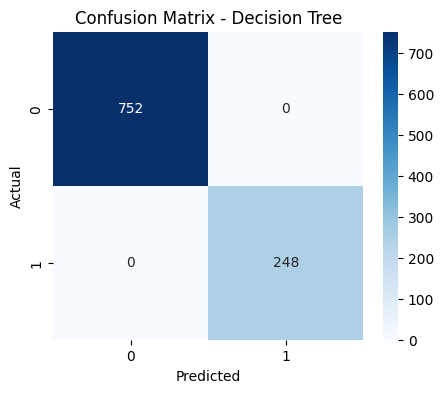

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

best_model_name = results_df.sort_values(
    by='F1-Score', ascending=False
).iloc[0]['Model']

best_preds = predictions[best_model_name]

cm = confusion_matrix(y_test, best_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions['ANN']))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       752
           1       0.91      0.93      0.92       248

    accuracy                           0.96      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000



In [39]:
ann.save_weights("ann_fraud.weights.h5")


In [40]:
import joblib

joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [41]:
feature_columns = X.columns.tolist()

joblib.dump(feature_columns, "feature_columns.joblib")


['feature_columns.joblib']

In [56]:
import tensorflow as tf
print(tf.__version__)


2.20.0
